# Open and convert
For AVIs, use cv2's `VideoCapture` class, then iterate through to convert it to a numpy array. Perform an averaging z-projection to get the background only (moving worms are removed). Convert to integers.

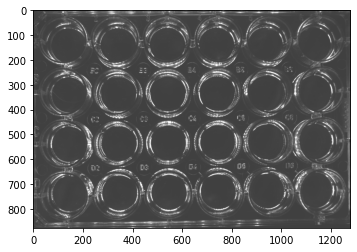

In [7]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import circle_perimeter
from skimage.filters import sobel, threshold_triangle
from skimage.transform import hough_circle, hough_circle_peaks

path = Path.home().joinpath('Desktop/20220527-p02-KTRb.avi')

vid = cv2.VideoCapture(str(path))
ret = True
frames = []
while ret:
    ret, img = vid.read()
    if ret:
        frames.append(img)

array = np.stack(frames, axis=0)
ave = np.mean(array, axis=0)
ave_int = ave.astype(int)

plt.imshow(ave_int)
plt.show()


# Segment wells
Find edges with a Sobel filter, use the triangle thresholding algorithm (this will require testing on different plates).

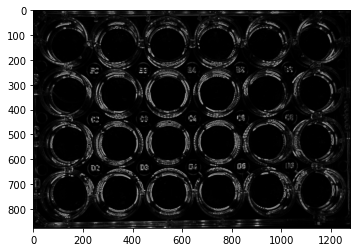

In [9]:
gry = cv2.cvtColor(ave.astype(np.float32), cv2.COLOR_BGR2GRAY)

edges = sobel(gry)

plt.imshow(edges, cmap='gray')
plt.show()


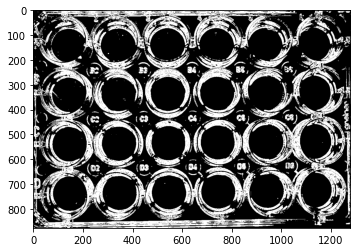

In [8]:
thresh = threshold_triangle(edges)
binary = edges > thresh

plt.imshow(binary, cmap='gray')
plt.show()


# Find circles
Use the Hough transform to find circles.

Search for circles with radii of 71, 73, and 75. Keep the top 200 circles. 

Filter circles that don't fall within a predefined grid (this requires the original video to be cropped to only include the plate...1280x880-ish). It's likely that more `elif` statements will be required to be robust to all videos.

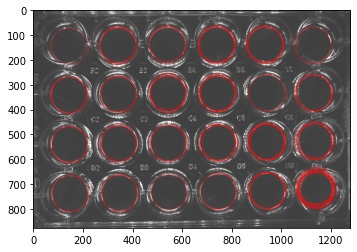

In [4]:
radii = np.arange(71, 75, 2)
hough_res = hough_circle(binary, radii)
accums, cx, cy, radii = hough_circle_peaks(
    hough_res, radii, total_num_peaks=200)

cy = np.ndarray.tolist(cy)
cx = np.ndarray.tolist(cx)
radii = np.ndarray.tolist(radii)

filtered_y = []
bad_indices = []
i = 0

for y in cy:
    if y < 100:
        bad_indices.append(i)
    elif y > 225 and y < 275:
        bad_indices.append(i)
    elif y > 400 and y < 450:
        bad_indices.append(i)
    elif y > 600 and y < 650:
        bad_indices.append(i)
    else:
        i += 1

for i in bad_indices:
    cy.pop(i)
    cx.pop(i)
    radii.pop(i)

ave_int = ave.astype(int)

fig, ax = plt.subplots(ncols=1, nrows=1)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    ave_int[circy, circx] = (220, 20, 20)

plt.imshow(ave_int)
plt.show()


# Draw a single circle per well
Fill the filtered objects and make binary. Find the center of mass of the filled objects (only 24, will require a future YAML argument in wrmXpress), then draw a circle with radius = 73 around each center of mass. Note that the order of the objects must be maintained.

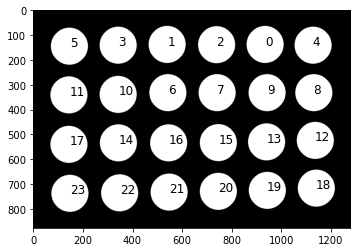

In [5]:
from scipy import ndimage
from skimage.morphology import dilation, reconstruction

black = np.zeros(ave_int.shape[0:2])

for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    black[circy, circx] = 1

closed = dilation(black)

seed = np.copy(closed)
seed[1:-1, 1:-1] = closed.max()
mask = closed

filled = reconstruction(seed, mask, method='erosion')

lbl, objects = ndimage.label(filled)
centers = ndimage.center_of_mass(filled, lbl, range(1, 25, 1))
object_n = []
for x, y in centers:
    x = int(x)
    y = int(y)
    object_n.append(lbl[x, y])

mask = np.zeros(lbl.shape)
for x, y in centers:
    x = int(x)
    y = int(y)
    circy, circx = circle_perimeter(x, y, 73)
    mask[circy, circx] = 1

closed = dilation(mask)

seed = np.copy(closed)
seed[1:-1, 1:-1] = closed.max()
mask = closed

filled_mask = reconstruction(seed, mask, method='erosion')

plt.imshow(filled_mask, cmap='gray')
for i, center, in enumerate(centers):
    y, x = center
    plt.text(x, y, i, fontsize=12)
plt.show()


# Optical flow
Code lifted from `BrugiaMotilityAnalysis` repo. Calculate the sum of each well by using the labelled mask and `ndi_sum()` (what a great function, btw). Make sure the order isn't messed up.

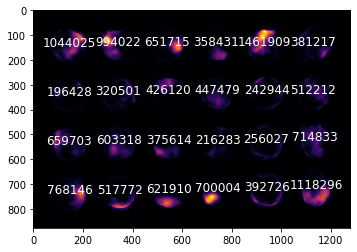

In [10]:

from scipy.ndimage import sum as ndi_sum

path = Path.home().joinpath('Desktop/20220527-p02-KTRb.avi')

vid = cv2.VideoCapture(str(path))

length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

vid_array = np.zeros((length, height, width))

# read first frame
ret, frame1 = vid.read()

# convert to gray scale
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
vid_array[0] = prvs

all_mag = np.zeros((length - 1, height, width))
# print(all_mag.shape)
count = 0
while(1):
    if count < length - 1:
        ret, frame2 = vid.read()
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        vid_array[count + 1] = next
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15,
                                            3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        prvs = next
        all_mag[count] = mag
        count += 1
        # for testing
        # if count > 4:
        #     break
    else:
        break

sum = np.sum(all_mag, axis=0)
masked_sum = sum * filled_mask
well_sums = ndi_sum(masked_sum, lbl, range(1, objects + 1, 1))

center_sums = []

for t, sum in zip(centers, well_sums):
    t = list(t)
    t.append(sum)
    center_sums.append(t)

plt.imshow(masked_sum, cmap='inferno')
for y, x, i in center_sums:
    plt.text(x, y, int(i), fontsize=12, ha='center', color='white')
plt.show()


# Schisto
Try with schisto in a 6-well plate

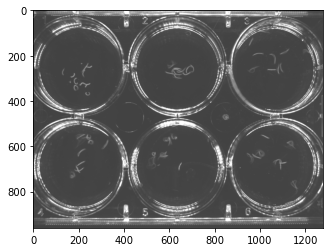

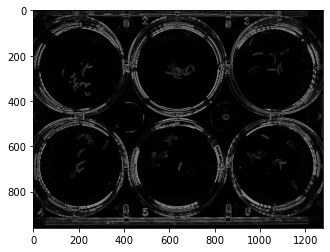

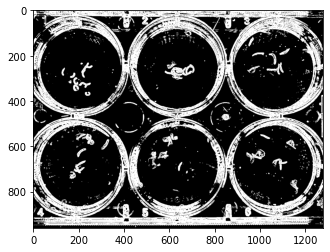

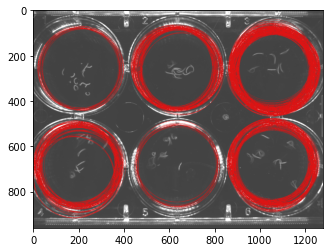

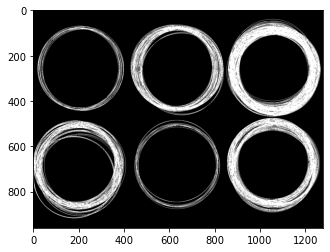

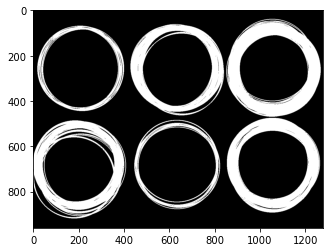

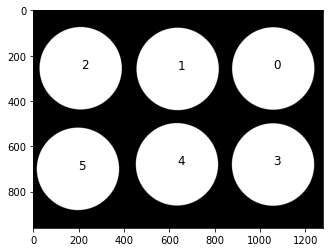

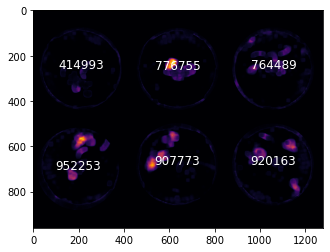

: 

In [28]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.ndimage import sum as ndi_sum
from skimage.draw import circle_perimeter
from skimage.filters import sobel, threshold_triangle
from skimage.morphology import dilation, reconstruction
from skimage.transform import hough_circle, hough_circle_peaks

path = Path.home().joinpath('Desktop/19_30.avi')

vid = cv2.VideoCapture(str(path))
ret = True
frames = []
while ret:
    ret, img = vid.read()
    if ret:
        frames.append(img)

array = np.stack(frames, axis=0)
ave = np.mean(array, axis=0)
ave_int = ave.astype(int)

plt.imshow(ave_int)
plt.show()

gry = cv2.cvtColor(ave.astype(np.float32), cv2.COLOR_BGR2GRAY)

edges = sobel(gry)

plt.imshow(edges, cmap='gray')
plt.show()


thresh = threshold_triangle(edges)
binary = edges > thresh

plt.imshow(binary, cmap='gray')
plt.show()


radii = np.arange(178, 182, 2)
hough_res = hough_circle(binary, radii)
accums, cx, cy, radii = hough_circle_peaks(
    hough_res, radii, total_num_peaks=400)

cy = np.ndarray.tolist(cy)
cx = np.ndarray.tolist(cx)
radii = np.ndarray.tolist(radii)


filtered_y = []
bad_indices = []
i = 0

for y in cy:
    if y < 200:
        bad_indices.append(i)
    elif y > 300 and y < 625:
        bad_indices.append(i)
    elif y > 750:
        bad_indices.append(i)
    else:
        i += 1

for i in bad_indices:
    cy.pop(i)
    cx.pop(i)
    radii.pop(i)

ave_int = ave.astype(int)

fig, ax = plt.subplots(ncols=1, nrows=1)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    ave_int[circy, circx] = (220, 20, 20)

plt.imshow(ave_int)
plt.show()

black = np.zeros(ave_int.shape[0:2])

for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius)
    black[circy, circx] = 1

plt.imshow(black, cmap='gray')
plt.show()

closed = dilation(black)

plt.imshow(closed, cmap='gray')
plt.show()

seed = np.copy(closed)
seed[1:-1, 1:-1] = closed.max()
mask = closed

filled = reconstruction(seed, mask, method='erosion')

lbl, objects = ndimage.label(filled)
centers = ndimage.center_of_mass(filled, lbl, range(1, objects + 1, 1))
object_n = []
for x, y in centers:
    x = int(x)
    y = int(y)
    object_n.append(lbl[x, y])

mask = np.zeros(lbl.shape)
for x, y in centers:
    x = int(x)
    y = int(y)
    circy, circx = circle_perimeter(x, y, 180)
    mask[circy, circx] = 1

closed = dilation(mask)

seed = np.copy(closed)
seed[1:-1, 1:-1] = closed.max()
mask = closed

filled_mask = reconstruction(seed, mask, method='erosion')

plt.imshow(filled_mask, cmap='gray')
for i, center, in enumerate(centers):
    y, x = center
    plt.text(x, y, i, fontsize=12)
plt.show()


path = Path.home().joinpath('Desktop/19_30.avi')

vid = cv2.VideoCapture(str(path))

length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

vid_array = np.zeros((length, height, width))

# read first frame
ret, frame1 = vid.read()

# convert to gray scale
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
vid_array[0] = prvs

all_mag = np.zeros((length - 1, height, width))
# print(all_mag.shape)
count = 0
while(1):
    if count < length - 1:
        ret, frame2 = vid.read()
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        vid_array[count + 1] = next
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15,
                                            3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        prvs = next
        all_mag[count] = mag
        count += 1
        # for testing
        # if count > 4:
        #     break
    else:
        break

sum = np.sum(all_mag, axis=0)
masked_sum = sum * filled_mask
well_sums = ndi_sum(masked_sum, lbl, range(1, objects + 1, 1))

center_sums = []

for t, sum in zip(centers, well_sums):
    t = list(t)
    t.append(sum)
    center_sums.append(t)

plt.imshow(masked_sum, cmap='inferno')
for y, x, i in center_sums:
    plt.text(x, y, int(i), fontsize=12, ha='center', color='white')
plt.show()
